## Workshop Week 6

## Logistic Regression
Breast Cancer data from [the UCI repository](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) contains records corresponding to 
cases of observed tumors.   There are a number of observations for each and a categorisation in the `class` column: 2 for benign (good), 4 for malignant (bad).  Your task is to build a logistic regression model to classify these cases. 

The data is provided as a CSV file.  There are a small number of cases where no value is available, these are indicated in the data with `?`. I have used the `na_values` keyword for `read_csv` to have these interpreted as `NaN` (Not a Number).  Your first task is to decide what to do with these rows. You could just drop these rows or you could [impute them from the other data](http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values).

You then need to follow the procedure outlined in the lecture for generating a train/test set, building and evaluating a model. Your goal is to build the best model possible over this data.   Your first step should be to build a logistic regression model using all of the features that are available.
  

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, plot_confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer

In [2]:
bcancer = pd.read_csv("files/breast-cancer-wisconsin.csv", na_values="?")
bcancer.head()

,sample_code_number,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [3]:
# Examine the data: check number of rows and number of columns
bcancer.shape

(699, 11)

In [4]:
# Look at the statistical summary of the dataframe
bcancer.describe()

,sample_code_number,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


First Findings: <br >
- All values are within a range from 1-10 so normalization is not required
- bare_nuclei has 16 missing values

In [5]:
# Check how many classes we do have from the "class" column
bcancer["class"].unique()

array([2, 4])

In [6]:
# Check number of samples for each class and comment whether dataset is balanced?
bcancer["class"].value_counts()

2    458
4    241
Name: class, dtype: int64

The number of records with benign cancer is almost double as high as the number of records for malignant cancer. Thus, the dataset is not balanced and could cause a problem, especially since the critical outcome the model should not miss is classifying malignant as malignant.

In [7]:
# Deal with the NaN values in the data
bcancer.isnull().values.any()

True

In [8]:
# check how many NaN values there are
bcancer.isnull().sum()

sample_code_number              0
clump_thickness                 0
uniformity_cell_size            0
uniformity_cell_shape           0
marginal_adhesion               0
single_epithelial_cell_size     0
bare_nuclei                    16
bland_chromatin                 0
normal_nucleoli                 0
mitoses                         0
class                           0
dtype: int64

In [9]:
# show records with NaN values
bcancer[bcancer["bare_nuclei"].isnull()]

,sample_code_number,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
23,1057013,8,4,5,1,2,NaN,7,3,1,4
40,1096800,6,6,6,9,6,NaN,7,8,1,2
139,1183246,1,1,1,1,1,NaN,2,1,1,2
145,1184840,1,1,3,1,2,NaN,2,1,1,2
158,1193683,1,1,2,1,3,NaN,1,1,1,2
164,1197510,5,1,1,1,2,NaN,3,1,1,2
235,1241232,3,1,4,1,2,NaN,3,1,1,2
249,169356,3,1,1,1,2,NaN,3,1,1,2
275,432809,3,1,3,1,2,NaN,2,1,1,2
292,563649,8,8,8,1,2,NaN,6,10,1,4


Since there are only 16 rows with missing values and this amount accounts for a tiny fraction of the total data, these rows will be removed.

In [10]:
# remove records with missing values
bcancer2 = bcancer.drop(index = bcancer.index[bcancer["bare_nuclei"].isnull()])

In [11]:
# check whether NaN values have been removed
bcancer2.isnull().values.any()

False

In [12]:
# Split your data into training(80%) and testing data (20%) and use random_state=142
X_train, X_test, y_train, y_test = train_test_split(bcancer2.drop(["class", "sample_code_number"], axis = 1), # drop target variable and unneeded
                                                    bcancer2["class"], 
                                                    stratify = bcancer2["class"], # same proportion of features in each set
                                                    test_size=0.2, 
                                                    random_state=142)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((546, 9), (137, 9), (546,), (137,))

In [13]:
# Build your Logistic Regression model
logmodel = LogisticRegression().fit(X_train, y_train)

print("y = X * ", logmodel.coef_, "+ ", logmodel.intercept_)

y = X *  [[ 0.5131087   0.03317505  0.26146369  0.24761474 -0.08318565  0.44588474
   0.46895376  0.19496211  0.3784014 ]] +  [-9.28390506]


In [16]:
# Do predictions on train and test set
predict_train = logmodel.predict(X_train)
predict_test = logmodel.predict(X_test)


In [54]:
# evaluate model on training and test data
def model_metrics(predicted, y):
    mse = mean_squared_error(y, predicted)
    r2 = r2_score(y, predicted)
    accuracy = accuracy_score(y, predicted)
    print("MSE :", round(mse, 2))
    print("R^2 :", round(r2, 2))
    print("Accuracy: ", round(accuracy*100, 2), "%")
    
model_metrics(predict_train, y_train)
model_metrics(predict_test, y_test)

MSE : 0.13
R^2 : 0.86
Accuracy:  96.7 %
MSE : 0.12
R^2 : 0.87
Accuracy:  97.08 %


On both datasets, the model achieved a very high accuracy that slightly increase on the test data. This is accompanied by satisfying goodness of fit which even slightly increased on testing data, indicating that overfitting is not a problem in this model.

### Evaluation

To evaluate a classification model we want to look at how many cases were correctly classified and how many
were in error.  In this case we have two outcomes - benign and malignant.   SKlearn has some useful tools, the 
[accuracy_score]() function gives a score from 0-1 for the proportion correct.  The 
[confusion_matrix](http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix) function 
shows how many were classified correctly and what errors were made.  Use these to summarise the performance of 
your model (these functions have already been imported above).

In [86]:
# Evaluate the performance of your trained model, calculate metrics for test data
model_metrics(predict_test, y_test)

MSE : 0.12
R^2 : 0.87
Accuracy:  97.08 %


In [34]:
# create confusion matrix on training data

cm_train = confusion_matrix(predict_train, y_train)
cm_train

array([[346,   9],
       [  9, 182]])

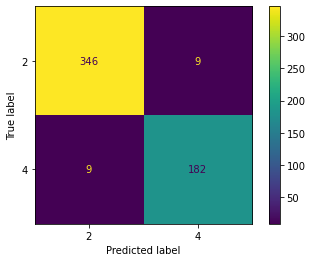

In [41]:
# visualise confusion matrix

# class 2 cancer as positive class
# class 4 cancer as negative class

plot_confusion_matrix(logmodel, X_train, y_train)

In [53]:
# calculate metrics from confusion matrix
def cm_metrics(cm):
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    True_Positive_Rate = TP/(TP+FN)
    True_Negative_Rate = TN/(TN+FP)
    Precision = TP/(TP+FP)
    False_Positive_Rate = FP/(TN+FP)
    print("True_Positive_Rate (Sensitivity):", round(True_Positive_Rate*100, 2), "%")
    print("True_Negative_Rate (Specificity):", round(True_Negative_Rate*100, 2), "%")
    print("Precision:", round(Precision*100, 2), "%")
    print("False_Positive_Rate:", round(False_Positive_Rate*100, 2), "%")
    
cm_metrics(cm_train)

True_Positive_Rate (Sensitivity): 97.46 %
True_Negative_Rate (Specificity): 95.29 %
Precision: 97.46 %
False_Positive_Rate: 4.71 %


In [35]:
# create confusion matrix on test data
cm_test = confusion_matrix(predict_test, y_test)
cm_test

array([[89,  4],
       [ 0, 44]])

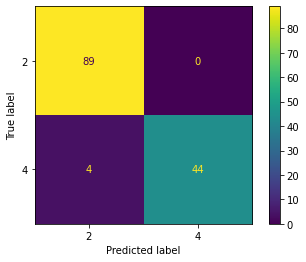

In [55]:
# visualise confusion matrix

# class 2 cancer as positive class
# class 4 cancer as negative class

plot_confusion_matrix(logmodel, X_test, y_test)

In [57]:
# calculate metrics from confusion matrix
cm_metrics(cm_test)

True_Positive_Rate (Sensitivity): 100.0 %
True_Negative_Rate (Specificity): 91.67 %
Precision: 95.7 %
False_Positive_Rate: 8.33 %


Overall, the model performs well on the data. This is indicated by high a accuracy score as well as R^2 on training and test data. However, in the case of cancer prediction, it is important to capture all malignant cases, thus, the goal should be to have perfect specificity. As can be seen in above though, the model rather has a high sensitivity and hence misses out on some of malignant cases and classifies them as benign.

**This is the checkpoint mark for this week's workshop. You need to report `Accuracy Score` on test set and also show `confusion matrix`. You also need to provide analysis based on the results you got.**

### Feature Selection

Since you have many features available, one part of building the best model will be to select which features to use as input to the classifier. Your initial model used all of the features but it is possible that a better model can 
be built by leaving some of them out.   Test this by building a few models with subsets of the features - how do your models perform? 

This process can be automated.  The [sklearn RFE function](http://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination) implements __Recursive Feature Estimation__ which removes 
features one by one, evaluating the model each time and selecting the best model for a target number of features.  Use RFE to select features for a model with 3, 4 and 5 features - can you build a model that is as good or better than your initial model?

In [79]:
from sklearn.feature_selection import RFECV

#init and fit
rfecv = RFECV(estimator=LogisticRegression(),
             min_features_to_select=3,
             scoring='accuracy')
selector = rfecv.fit(X_train, y_train)

# show selected features
supp = rfecv_fit.support_

In [68]:
# show ranking of features
rfecv_fit.ranking_

array([1, 4, 1, 1, 3, 1, 1, 2, 1])

In [69]:
# print optimal number of features
print("Optimal number of features: {}".format(rfecv.n_features_))

Optimal number of features: 6


In [82]:
print("Coefficients: ", selector.estimator_.coef_)
print("Intercept: ", selector.estimator_.intercept_)

Coefficients:  [[0.535687   0.35151067 0.26258984 0.43584877 0.51929627 0.37961416]]
Intercept:  [-9.41053442]


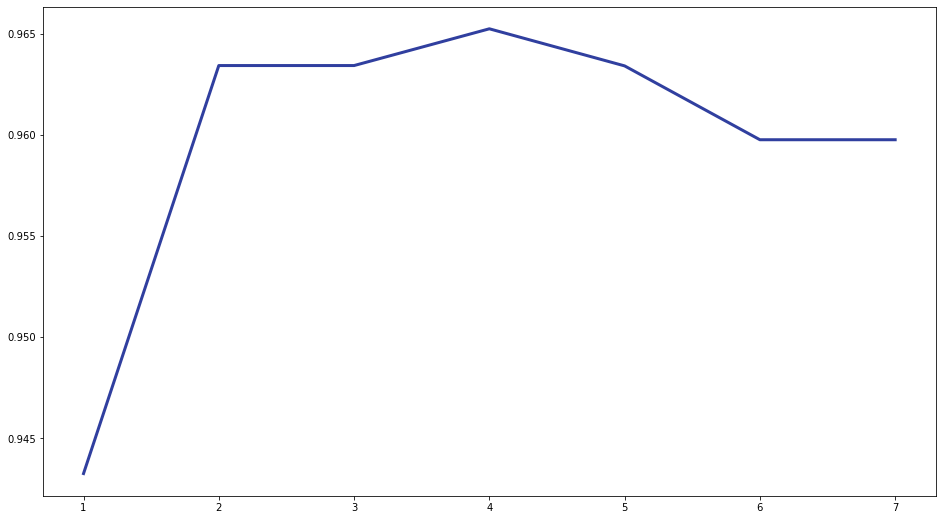

In [72]:
# show accuracy for each number of features used
plt.figure(figsize=(16,9))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

In [87]:
# predictions on train and test data
rfecv_predict_train = selector.predict(X_train)
rfecv_predict_test = selector.predict(X_test)

#print("Metrics on training data:", model_metrics(rfecv_predict_train, y_train))
model_metrics(rfecv_predict_train, y_train)
#print("Metrics on testing data:\n", model_metrics(rfecv_predict_test, y_test))
model_metrics(rfecv_predict_test, y_test)


MSE : 0.12
R^2 : 0.86
Accuracy:  96.89 %
MSE : 0.15
R^2 : 0.84
Accuracy:  96.35 %


## Conclusion

Write a brief conclusion to your experiment.  You might comment on the proportion of __false positive__ and __false negative__ classifications your model makes.  How useful would this model be in a clinical diagnostic setting? 